C:\ProgramData\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 1.1149 - accuracy: 0.6055

C:\Users\abhij\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 212s 3s/step - loss: 1.1149 - accuracy: 0.6055 - val_loss: 0.7728 - val_accuracy: 0.7210
Epoch 2/10
61/61 [==============================] - 188s 3s/step - loss: 0.8682 - accuracy: 0.6627 - val_loss: 0.7467 - val_accuracy: 0.7195
Epoch 3/10
61/61 [==============================] - 195s 3s/step - loss: 0.7609 - accuracy: 0.7175 - val_loss: 0.7192 - val_accuracy: 0.7088
Epoch 4/10
61/61 [==============================] - 193s 3s/step - loss: 0.7397 - accuracy: 0.7273 - val_loss: 0.6973 - val_accuracy: 0.7332
Epoch 5/10
61/61 [==============================] - 190s 3s/step - loss: 0.7264 - accuracy: 0.7283 - val_loss: 0.7027 - val_accuracy: 0.7378
Epoch 6/10
61/61 [==============================] - 194s 3s/step - loss: 0.6753 - accuracy: 0.7485 - val_loss: 0.7027 - val_accuracy: 0.7332
Epoch 7/10
61/61 [==============================] - 194s 3s/step - loss: 0.6716 - accuracy: 0.7438 - val_loss: 0.6809 - val_accuracy: 0.7409
Epoch 8/10
61/61 [======

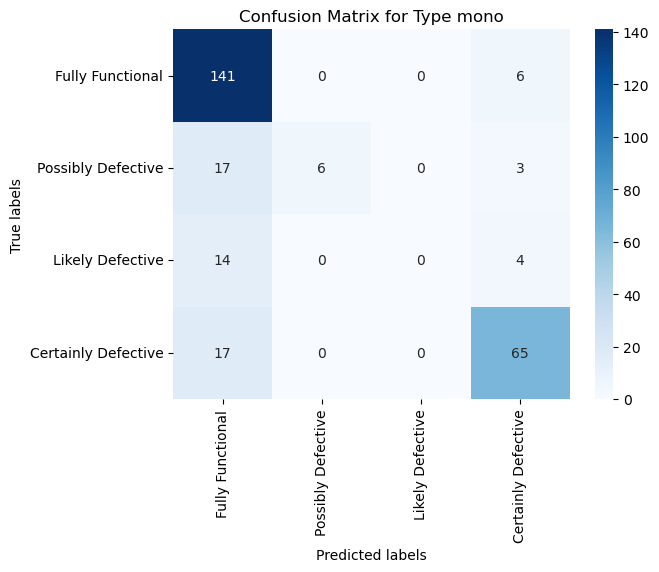

Confusion Matrix for Type poly:
[[207   2   0  16]
 [ 30  12   0   5]
 [  9   1   0   3]
 [ 17   2   0  79]]

Classification Report for Type poly:
                     precision    recall  f1-score   support

   Fully Functional       0.79      0.92      0.85       225
 Possibly Defective       0.71      0.26      0.37        47
   Likely Defective       0.00      0.00      0.00        13
Certainly Defective       0.77      0.81      0.79        98

           accuracy                           0.78       383
          macro avg       0.56      0.50      0.50       383
       weighted avg       0.75      0.78      0.75       383



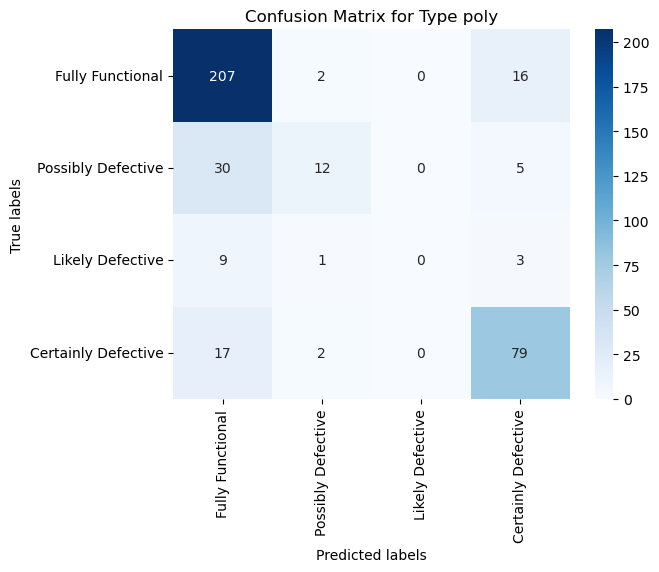

Confusion Matrix for Entire Dataset:
[[348   2   0  22]
 [ 47  18   0   8]
 [ 23   1   0   7]
 [ 34   2   0 144]]

Classification Report for Entire Dataset:
                     precision    recall  f1-score   support

   Fully Functional       0.77      0.94      0.84       372
 Possibly Defective       0.78      0.25      0.38        73
   Likely Defective       0.00      0.00      0.00        31
Certainly Defective       0.80      0.80      0.80       180

           accuracy                           0.78       656
          macro avg       0.59      0.50      0.50       656
       weighted avg       0.74      0.78      0.74       656



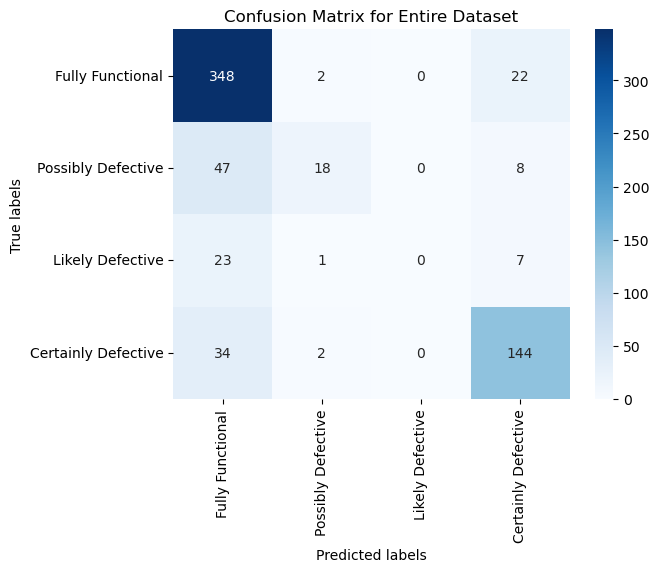

In [2]:
# Import necessary libraries
import numpy as np
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Data
fname='elpv-dataset-1.0/labels.csv'


# Load the dataset
data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
image_fnames = np.char.decode(data['path'])
probs = data['probability']
types = np.char.decode(data['type'])

# Define a function to preprocess the images
def load_and_preprocess_image(fname):
    with Image.open(fname) as image:
        # Preprocess image for ResNet50
        image = image.convert('RGB')
        image = image.resize((224, 224))
        image = np.array(image)
        image = preprocess_input(image)  # Use the imported function here
        return image

# Load and preprocess images
dir = os.path.dirname(fname)
images = np.array([load_and_preprocess_image(os.path.join(dir, fn))
                   for fn in image_fnames])

# Convert probabilities to categorical labels
labels = to_categorical(np.round(probs * 3), num_classes=4)


# One hot encode the types variable

label_encoder = LabelEncoder()
integer_encoded_types = label_encoder.fit_transform(types)

# One-hot encode the integer labels
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_types = integer_encoded_types.reshape(len(integer_encoded_types), 1)
onehot_encoded_types = onehot_encoder.fit_transform(integer_encoded_types)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test, type_train, type_test = train_test_split(
    images, labels, onehot_encoded_types, test_size=0.25, random_state=42)

# Define two inputs for the model: one for the image and one for the module type
image_input = Input(shape=(224, 224, 3))
type_input = Input(shape=(onehot_encoded_types.shape[1],))  # The shape of the type input

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Use the base model for the image input
x1 = base_model(image_input)
x1 = GlobalAveragePooling2D()(x1)

# Combine the output of the base model with the type input
combined = Concatenate()([x1, type_input])

# Add your custom layers on top
x = Dense(1024, activation='relu')(combined)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the final model with two inputs
model = Model(inputs=[image_input, type_input], outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to stop training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



# Train the model with both image and type inputs
history = model.fit(
    [X_train, type_train], y_train, 
    epochs=10, 
    steps_per_epoch=len(X_train) // 32,
    batch_size=32, 
    validation_data=([X_test, type_test], y_test), 
    callbacks=[early_stopping, model_checkpoint]
)


# Predict the test set results
y_pred = model.predict([X_test, type_test])
y_pred_classes = np.argmax(y_pred, axis=1)


# Accuracy stats
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Convert type_test from one-hot encoding to original labels
type_test_labels = label_encoder.inverse_transform(np.argmax(type_test, axis=1))

# Unique types
unique_types = np.unique(type_test_labels)

# Evaluate for each type
for t in unique_types:
    # Indices for current type
    indices = np.where(type_test_labels == t)

    # Subset y_test_classes and y_pred_classes
    y_test_subset = y_test_classes[indices]
    y_pred_subset = y_pred_classes[indices]

    # Confusion Matrix for current type
    cm = confusion_matrix(y_test_subset, y_pred_subset)
    print(f"Confusion Matrix for Type {t}:")
    print(cm)

    # Classification Report for current type
    report = classification_report(y_test_subset, y_pred_subset, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division = 0)
    print(f"\nClassification Report for Type {t}:")
    print(report)

    # Visualization of Confusion Matrix for current type
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()

    
cm_total = confusion_matrix(y_test_classes, y_pred_classes)
report_total = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division=0)

print("Confusion Matrix for Entire Dataset:")
print(cm_total)
print("\nClassification Report for Entire Dataset:")
print(report_total)

sns.heatmap(cm_total, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Dataset')
plt.show()